In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from toolz import reduce

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig4-longv2-bambi", tight_layout=False)

In [3]:
keep_syllables = np.loadtxt(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
    dtype=int,
)
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet"
)

df = df[keep_syllables].astype(float)

fdf = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet"
)

fdf = fdf[keep_syllables].astype(float)

In [4]:
# sort_syllables = df.quantile(0.95).sort_values(ascending=False).index
# sort_syllables = df.std().sort_values(ascending=False).index

In [5]:
age = df.index.get_level_values("age")
bins = pd.cut(age, 40, labels=False)
sort_syllables = df.groupby(bins, observed=True).mean().quantile(0.95).sort_values(ascending=False).index

In [6]:
for mouse, _df in df.groupby('mouse'):
    break

m_age = _df.index.get_level_values('age')

windows = np.arange(1, 51)

cuts = pd.cut(m_age, windows)

samples = []
index = []
for _bin, win_df in _df.groupby(cuts, observed=True):
    _sample = win_df.iloc[:2].mean()
    samples.append(_sample)
    index.append(win_df.index[0])
samples = pd.DataFrame(samples, index=pd.MultiIndex.from_tuples(index, names=win_df.index.names))

reset_samples = samples.reset_index()

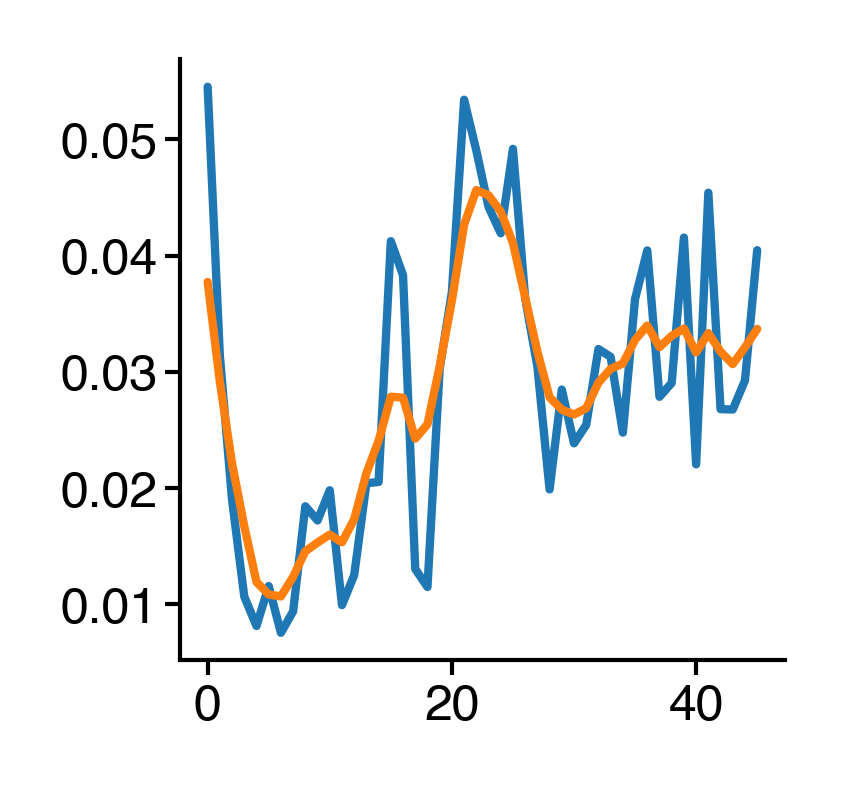

In [7]:
fig = figure(1.3, 1.3)
ax = reset_samples[5].plot()
reset_samples[5].rolling(7, center=True, min_periods=1, win_type='exponential').mean(tau=2).plot(ax=ax)
sns.despine()

In [8]:
# smooth for each animal

In [9]:
def merge(left, right):
    return pd.merge(left, right, left_index=True, right_index=True, how='outer')

In [10]:
windows = np.arange(1, 51)

norms = {}
_ages = {}
for mouse, _df in df.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    cuts = pd.cut(m_age, windows)

    samples = []
    index = []
    for _bin, win_df in _df.groupby(cuts, observed=True):
        _sample = win_df.iloc[:2].mean()
        samples.append(_sample)
        index.append(win_df.index[0])
    samples = pd.DataFrame(samples, index=pd.MultiIndex.from_tuples(index, names=win_df.index.names))[sort_syllables[:25]]

    smooth_samples = samples.rolling(7, center=True, min_periods=1, win_type='exponential').mean(tau=2)
    normed = np.linalg.norm(smooth_samples.diff(), axis=1)
    _ages[mouse] = smooth_samples.index.get_level_values('age')
    norms[mouse] = pd.Series(normed, index=_ages[mouse].astype(int), name=mouse)
    norms[mouse] = norms[mouse][~norms[mouse].index.duplicated(keep='first')]
norms = reduce(merge, norms.values())

mask = norms.isna().sum(1) < 10
norms = norms[mask]
norms_melt = norms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')

In [11]:
windows = np.arange(1, 51)

fnorms = {}
for mouse, _df in fdf.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    cuts = pd.cut(m_age, windows)

    samples = []
    index = []
    for _bin, win_df in _df.groupby(cuts, observed=True):
        _sample = win_df.iloc[:2].mean()
        samples.append(_sample)
        index.append(win_df.index[0])
    samples = pd.DataFrame(samples, index=pd.MultiIndex.from_tuples(index, names=win_df.index.names))[sort_syllables[:25]]

    smooth_samples = samples.rolling(7, center=True, min_periods=1, win_type='exponential').mean(tau=2)
    normed = np.linalg.norm(smooth_samples.diff(), axis=1)
    _ages = smooth_samples.index.get_level_values('age').astype(int)
    fnorms[mouse] = pd.Series(normed, index=_ages, name=mouse)
    fnorms[mouse] = fnorms[mouse][~fnorms[mouse].index.duplicated(keep='first')]

fnorms = reduce(merge, fnorms.values())
fmask = fnorms.isna().sum(1) < 10
fnorms = fnorms[fmask]

fnorms_melt = fnorms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')

<Axes: xlabel='age', ylabel='ar'>

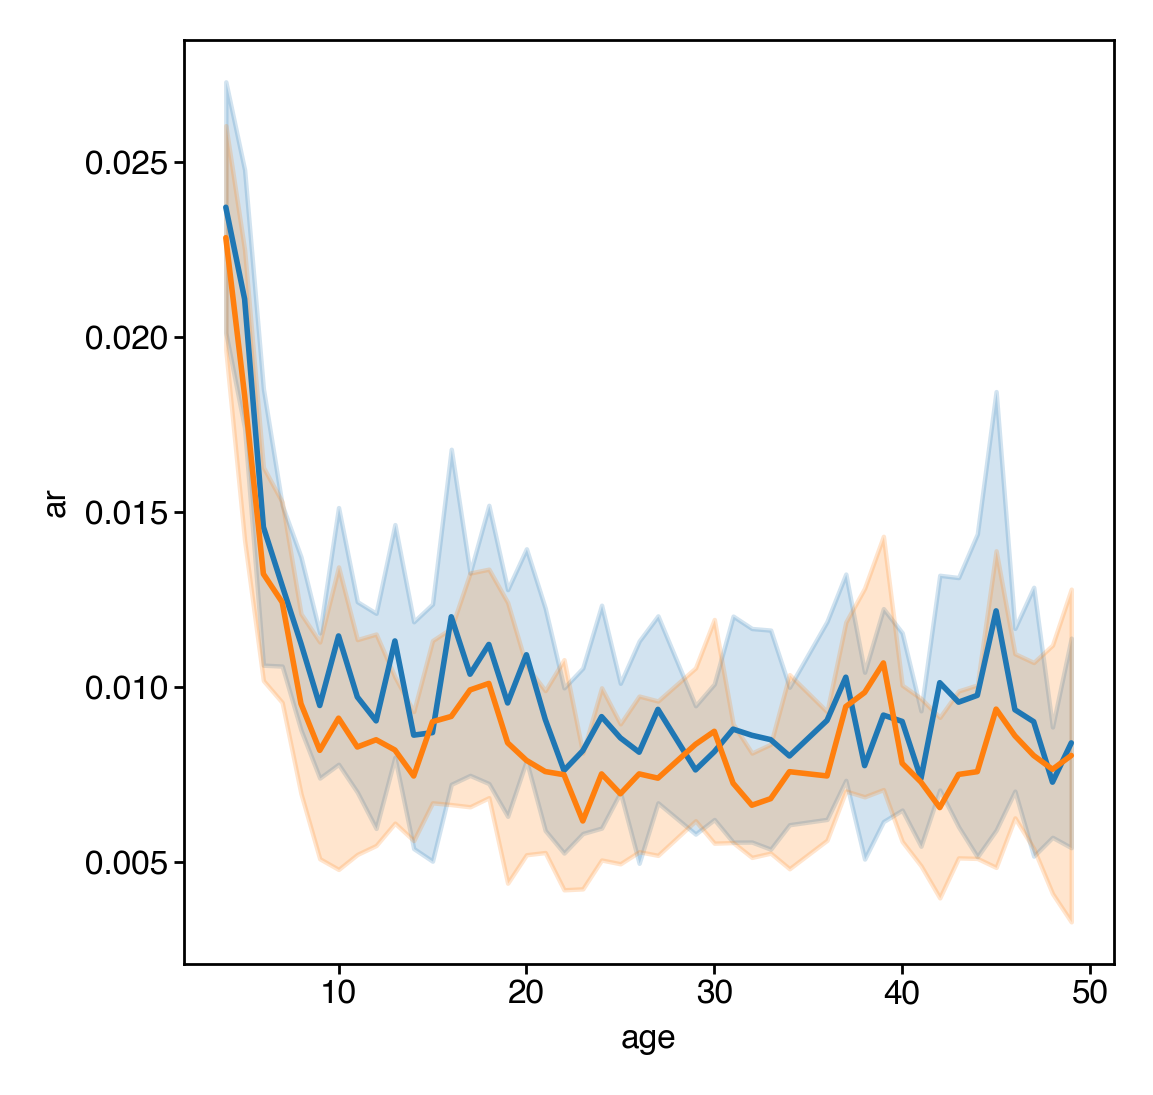

In [12]:
ax = sns.lineplot(data=norms_melt, x='age', y='ar', errorbar='sd')
sns.lineplot(data=fnorms_melt, x='age', y='ar', errorbar='sd', ax=ax)

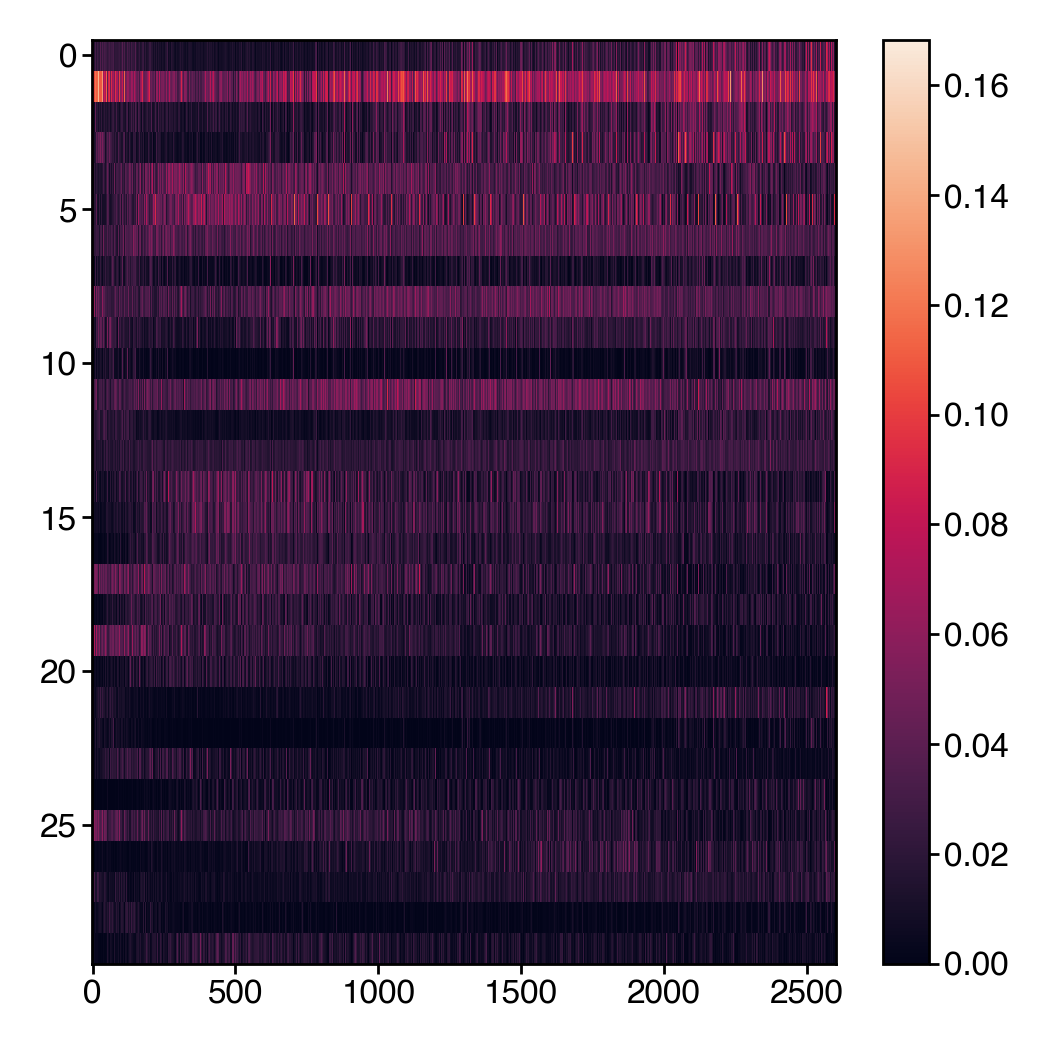

In [13]:
plt.imshow(fdf[sort_syllables[:30]].sort_index(level='age').T, aspect='auto', interpolation='none')
plt.colorbar()

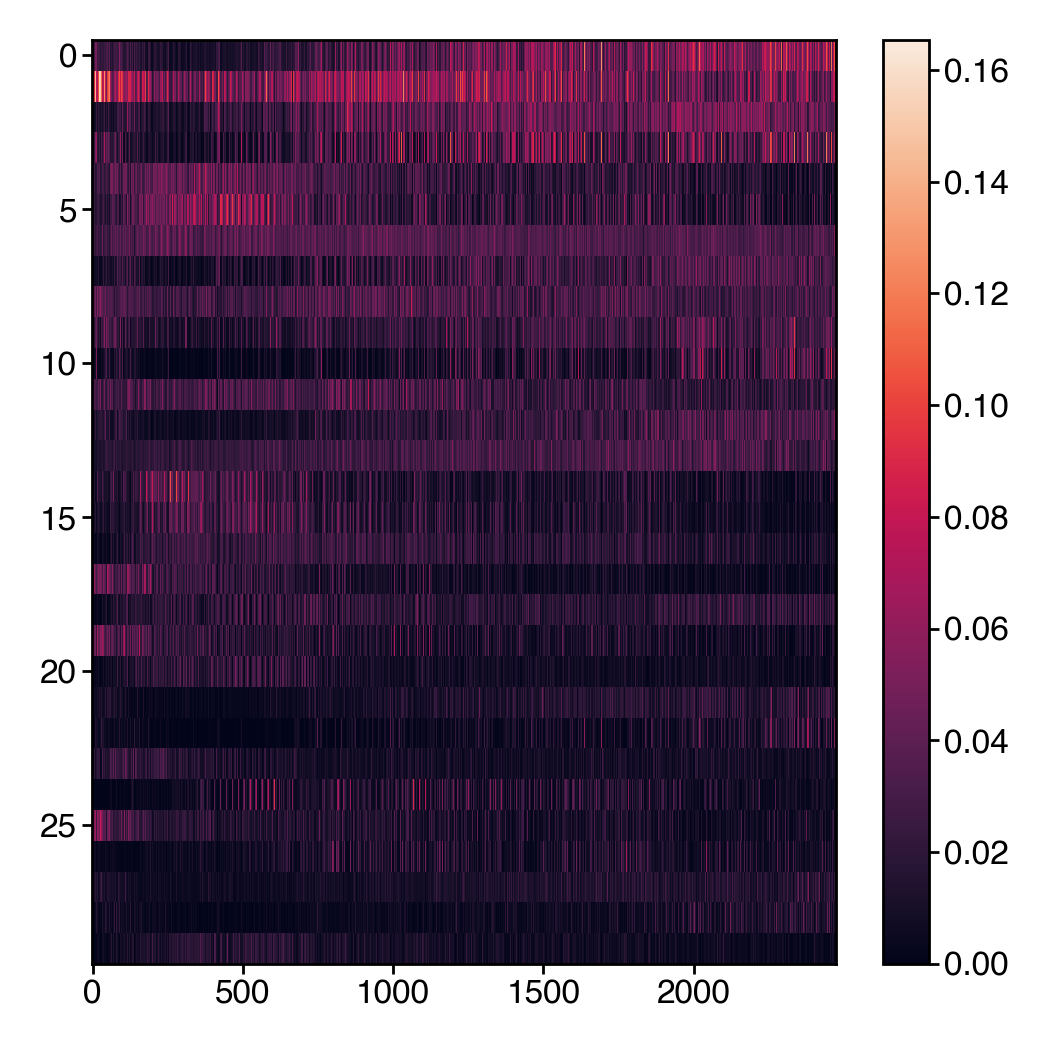

In [14]:
plt.imshow(df[sort_syllables[:30]].sort_index(level='age').T, aspect='auto', interpolation='none')
plt.colorbar()

## Try looking at variance

In [15]:
windows = np.arange(1, 51)

n_sylls = 25
roll_size = 7

norms = {}
for mouse, _df in df.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    cuts = pd.cut(m_age, windows)

    samples = []
    index = []
    for _bin, win_df in _df.groupby(cuts, observed=True):
        _sample = win_df.iloc[:2].mean()
        samples.append(_sample)
        index.append(win_df.index[0])
    samples = pd.DataFrame(samples, index=pd.MultiIndex.from_tuples(index, names=win_df.index.names))[sort_syllables[:n_sylls]]

    smooth_samples = samples.rolling(roll_size, center=True).std().mean(1)
    _ages = smooth_samples.index.get_level_values('age').astype(int)
    norms[mouse] = pd.Series(smooth_samples.to_numpy(), index=_ages, name=mouse)
    norms[mouse] = norms[mouse][~norms[mouse].index.duplicated(keep='first')]

norms = reduce(merge, norms.values())

mask = norms.isna().sum(1) < 10
norms = norms[mask]
norms_melt = norms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')

fnorms = {}
for mouse, _df in fdf.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    cuts = pd.cut(m_age, windows)

    samples = []
    index = []
    for _bin, win_df in _df.groupby(cuts, observed=True):
        _sample = win_df.iloc[:2].mean()
        samples.append(_sample)
        index.append(win_df.index[0])
    samples = pd.DataFrame(samples, index=pd.MultiIndex.from_tuples(index, names=win_df.index.names))[sort_syllables[:n_sylls]]

    smooth_samples = samples.rolling(roll_size, center=True).std().mean(1)
    _ages = smooth_samples.index.get_level_values('age').astype(int)
    fnorms[mouse] = pd.Series(smooth_samples.to_numpy(), index=_ages, name=mouse)
    fnorms[mouse] = fnorms[mouse][~fnorms[mouse].index.duplicated(keep='first')]

fnorms = reduce(merge, fnorms.values())

mask = fnorms.isna().sum(1) < 10
fnorms = fnorms[mask]
fnorms_melt = fnorms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')

webf NOT subset; don't know how to subset; dropped


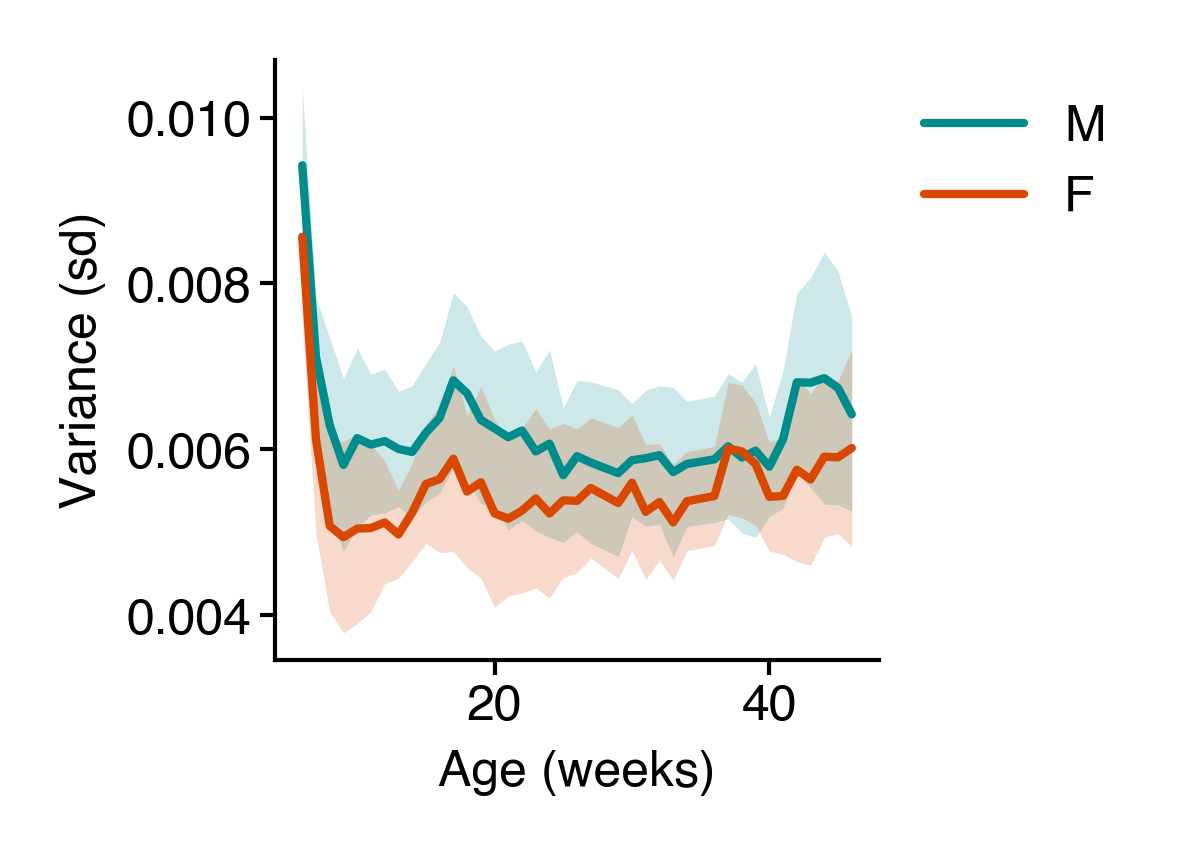

In [18]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(data=norms_melt, x='age', y='ar', errorbar='sd', err_kws=dict(lw=0), color=COLORMAPS.ont_male(255), label="M")
sns.lineplot(data=fnorms_melt, x='age', y='ar', errorbar='sd', ax=ax, err_kws=dict(lw=0), color=COLORMAPS.ont_female(255), label="F")
ax.set(ylabel="Variance (sd)", xlabel="Age (weeks)")
legend(ax)
sns.despine()
saver(fig, "mf-behavior-changes");